# Computing Particle Exit Angles

The goal of this code is the explore the directionality of gas particles exiting satellites, to help distinguish between particles lost by ram pressure stripping, tidal stripping, and SNe feedback.

`-- Hollis Akins, May 25 2021 --`

## Table of Contents

- [Proof of Concept](#proof)
- [Exit Angles by Distance](#distance)
- [Exit Angles by Ram Pressure Ratio](#rampressure)
- [Examining Outliers](#outliers)

In [2]:
from analysis import *

## Proof of Concept <a class="anchor" id="proof"></a>

We start by reading in the dataset of gas particles that were just "ejected" from the dist or "expelled" from the satellite as a whole. The function used to generate this dataset is stored in `analysis.py`. As part of identifying ejected/expelled gas particles, we also compute the exit angle of the gas particles relative to the velocity vector of the satellite. 

If the exit angle (angle between these vectors) is generally around 0, then we know that the particles are generally moving the same direction as the CGM relative to the satellite, a clear signature of ram pressure stripping. If the angle is more uniformly distributed, the particles are leaving in every direction, a more clear signature of feedback or tidal stripping. If we see a double-peaked distribution, that would be a clear signature of tidal stripping. 

In [3]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
Returning (ejected, cooled, expelled, accreted) for all available satellites...


This next bit is somewhat complicated, and it took me a while to realize that it was necessary. In order to represent the distribution of exit angles, we need to bin the data in bins of unequal size. This is because the angle we have calculated is effectively the colatitude of the sphere, or $\theta$ in spherical coordinates. The part of the sphere with $\theta \approx 90^\circ$ (the equator) is much larger in area than the part of the sphere with $\theta \approx 0^\circ$ or $\theta \approx 180^\circ$ (the poles). That is, we are bound to see a lot more particles exit with $\theta$ near $90^\circ$ than at the poles, as there is more area at which they can exit. 

In a closer read of Bahé et al. (2015), I realized that they bin the data into "20 bins of equal solid angle," such that if the distribution of $\theta$ was perfectly random, each bin would have 5% of the distribution. We do the same here. 

The total solid angle bounded by two colatitude angles $\theta_1$ and $\theta_2$ is given by 
$$\Omega = \iint_S \sin\theta\,d\theta\,d\phi = 2\pi \int_{\theta_1}^{\theta_2} \sin\theta\,d\theta = 2\pi~\left[-\cos\theta_2 + \cos\theta_1\right]$$
Since the entire sphere has solid angle of $\Omega = 4\pi$, if we want $N$ bins total then we need to construct our bins such that each one has solid angle $4\pi/N$. Thus,
$$\frac{4\pi}{N} = 2\pi~[\cos\theta_1 - \cos\theta_2]$$
$$2\pi \cos\theta_2 = 2\pi\cos\theta_1 - \frac{4\pi}{N}$$
$$\theta_2 = \arccos\left( \cos\theta_1 - \frac{2}{N} \right)$$
We construct our bins iteratively using this equation under a loop:

In [5]:
N = 20
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

Now that we have our bins, we also need to consider weighting our data. While most of our gas particles are the same  mass, it is more robust to weight by particle mass, and also aids in the interpretation of the histogram, as we can interpret the $y$-axis as the fraction of the total gas mass ejected that is ejected at that angle of $\theta$. We construct our weights as:

In [6]:
ejected['weight'] = ejected['mass'] / ejected['mass'].sum()
expelled['weight'] = expelled['mass'] / expelled['mass'].sum()

It is now time to construct our plot!

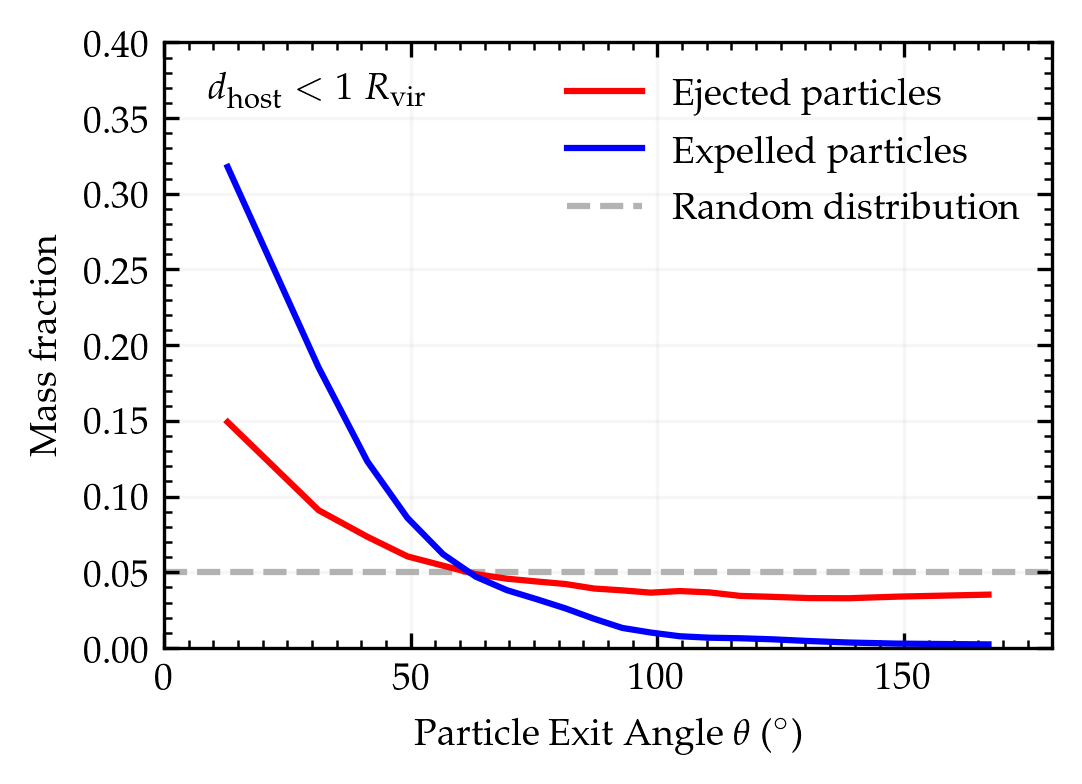

In [8]:
sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(ejected.hostRvir)

sat_pos = np.array([np.array(expelled.sat_Xc), np.array(expelled.sat_Yc), np.array(expelled.sat_Zc)]).T
host_pos = np.array([np.array(expelled.host_Xc), np.array(expelled.host_Yc), np.array(expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(expelled.hostRvir)

fig, ax = plt.subplots(1,1,dpi=300, figsize=(3.5,2.5), constrained_layout=True)

cond = pos_mag1 < 1
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax.plot(bincenters, y1, label='Ejected particles', c='r')

cond = pos_mag2 < 1
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax.plot(bincenters, y2, label='Expelled particles', c='b')

# plot the line that represents a random distribution
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='Random distribution')

# add legends
ax.legend(frameon=False)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.4)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.1, zorder=-1000)
ax.annotate(r'$d_{\rm host} < 1~R_{\rm vir}$', (0.05, 0.95), xycoords='axes fraction', va='top')

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

This plot provides clear evidence that ram pressure stripping is active in removing gas from the halo and (to a lesser degree) from the disk.

## Exit Angles by Distance <a class="anchor" id="distance"></a>

First load in the ejected, expelled datasets.

In [4]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
Returning (ejected, cooled, expelled, accreted) for all available satellites...


In [5]:
N = 20 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

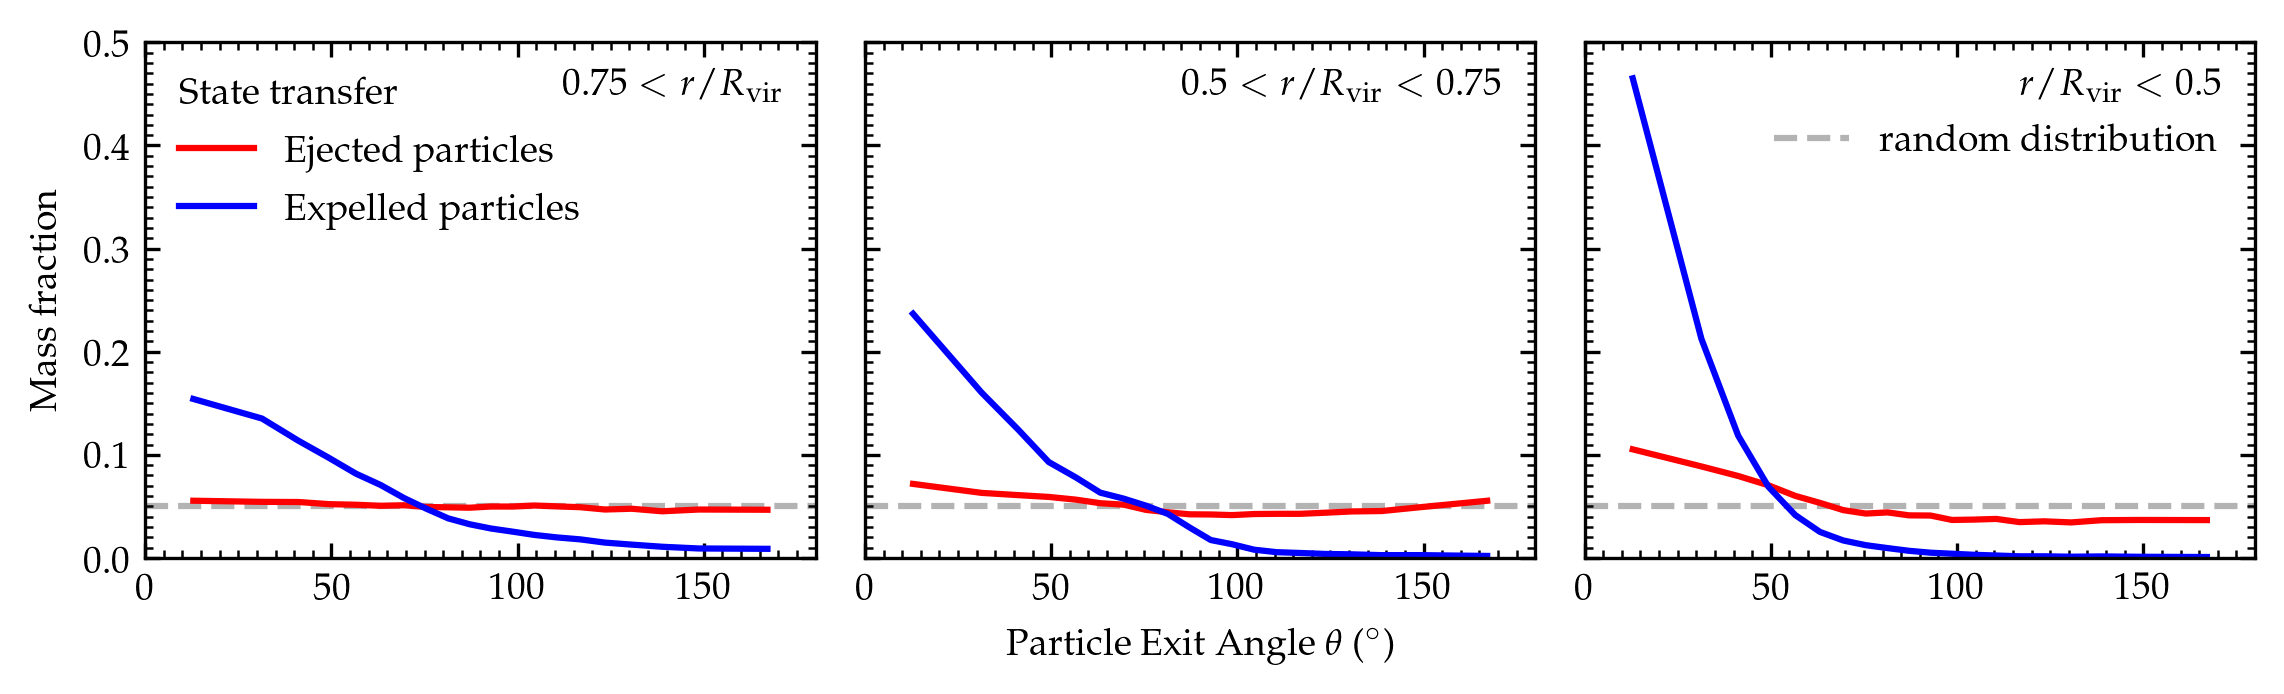

In [6]:
sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(ejected.hostRvir)

sat_pos = np.array([np.array(expelled.sat_Xc), np.array(expelled.sat_Yc), np.array(expelled.sat_Zc)]).T
host_pos = np.array([np.array(expelled.host_Xc), np.array(expelled.host_Yc), np.array(expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(expelled.hostRvir)

fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True)

# leftmost ax will be r > 0.75
ax[0].annotate(r'$0.75 < r/R_{\rm vir}$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 >= 0.75
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
l1 = r'Ejected particles'
ax[0].plot(bincenters, y1, label=l1, color='r')

cond = pos_mag2 > 0.75
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
l2 = r'Expelled particles'
ax[0].plot(bincenters, y2, label=l2, color='b')


# middle ax will be 0.5 < r < 0.75
ax[1].annotate(r'$0.5 < r/R_{\rm vir} < 0.75$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = (pos_mag1 >= 0.5) & (pos_mag1 < 0.75)
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax[1].plot(bincenters, y1, color='r')

cond = (pos_mag2 >= 0.5) & (pos_mag2 < 0.75)
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax[1].plot(bincenters, y2, color='b')


# rightmost ax will be r < 0.5
ax[2].annotate(r'$r/R_{\rm vir} < 0.5$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 < 0.5
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax[2].plot(bincenters, y1, color='r')

cond = pos_mag2 < 0.5
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax[2].plot(bincenters, y2, color='b')


# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title='State transfer', loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.5)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

## Exit Angles by Ram Pressure Ratio <a class="anchor" id="rampressure"></a>

In [7]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
Returning (ejected, cooled, expelled, accreted) for all available satellites...


In [8]:
path = '../../Data/ram_pressure.hdf5'
ram_pressure = pd.DataFrame()

with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

for key in keys:
    d = pd.read_hdf(path, key=key)
    d['key'] = key
    ram_pressure = pd.concat([ram_pressure, d])
    
ram_pressure.head()

,t,a,h1dist,dNN,M_star,M_gas,satRvir,hostRvir,vel_CGM,rho_CGM,...,rho_CGM_adv,std_vel_CGM,std_rho_CGM,Pram_adv,Prest,SigmaGas,dphidz,SFR,sSFR,key
0,6.474131,0.537186,423.531296,178.684714,100847839.53591666,314970038.6902275,42.360119,177.866525,184.559286,218.474060,...,458.98931660712736,7.983066,209.16724495036166,194286.52639588623,70906067.03846446,170201.660478939,416.600325,0.006685,6.62895e-11,h148_13
0,6.905111,0.563402,361.437487,178.728207,101175469.43702735,308855984.29167813,44.759939,188.949459,202.219302,259.355120,...,662.0364104629074,18.996878,297.001715177182,467552.32845517993,60500181.96811111,142372.95083385304,424.941547,0.006486,6.41029e-11,h148_13
0,7.039793,0.571574,340.566235,178.166036,101182058.5286643,301198403.8916383,45.468217,192.398621,208.994033,333.859921,...,795.3245987113976,21.531193,361.24019217524454,815914.7954962957,65630573.398863465,156325.7031222481,419.832261,0.002601,2.57041e-11,h148_13
0,7.336092,0.589531,292.055470,175.412003,101457993.92692062,277943421.0439347,47.157674,200.539727,225.969959,852.895770,...,1156.5488973193503,43.748361,617.7729346214282,4437030.714881859,89306071.6931496,213625.2056783062,418.050255,0.004567,4.50179e-11,h148_13
0,7.767072,0.615628,213.638074,164.678961,101922259.70865524,159423887.21248782,49.372360,218.455662,251.073050,1511.600202,...,2865.357386220595,20.478919,3021.5777796497846,144504078.89391506,2095343647.2374294,5096302.225314851,411.149801,0.004102,4.02489e-11,h148_13


In [9]:
ejected_merged = pd.merge(ejected, ram_pressure, right_on=['key','t'], left_on=['key', 'time'])
expelled_merged = pd.merge(expelled, ram_pressure, right_on=['key','t'], left_on=['key', 'time'])
ejected_merged.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,vel_CGM_adv,rho_CGM_adv,std_vel_CGM,std_rho_CGM,Pram_adv,Prest,SigmaGas,dphidz,SFR,sSFR
0,11.214915,2202002,0.000120,53035.859375,28366.376150,10.908183,6.698204,0.121201,0.612335,-0.205156,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
1,11.214915,4073949,0.000031,54464.347656,26965.973341,11.058858,11.656469,0.210918,-5.592503,8.339077,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
2,11.214915,4340176,0.001112,14165.883789,27285.939882,10.685118,3.025277,0.054741,-2.653128,-0.498549,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
3,11.214915,5212688,0.018649,9826.400391,27174.549484,0.000000,1.021319,0.018480,0.204697,0.741898,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
4,11.214915,6988228,0.208150,17343.492188,26798.731448,11.038656,0.824147,0.014913,-0.238316,0.661909,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12


In [10]:
P_rest_ej = np.array(ejected_merged.Prest,dtype=float)
P_ram_ej = np.array(ejected_merged.Pram_adv,dtype=float)
P_rest_ex = np.array(expelled_merged.Prest,dtype=float)
P_ram_ex = np.array(expelled_merged.Pram_adv,dtype=float)

ratio_ej = P_ram_ej/P_rest_ej
ratio_ex = P_ram_ex/P_rest_ex

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [11]:
def plot_panel(N, ax, ejected, expelled, label=False):
    theta1,theta2 = 0,0 # initialize
    bins = np.array([theta1]) 
    while theta2 < 3.14:
        theta2 = np.arccos(np.cos(theta1)-(2/N))
        bins = np.append(bins,theta2)
        theta1 = theta2

    bins = bins*180/np.pi
    bincenters = 0.5*(bins[1:]+bins[:-1])
    
    if label:
        labels = ['Heating from disk','Expulsion from disk','Outflow (heating or expulsion) from disk', 'Outflow (expulsion) from halo']
    else:
        labels = [None]*4
    
    e = pd.concat([ejected, expelled[expelled.state1=='sat_disk']])
    y1, bins = np.histogram(e.angle, bins=bins, weights=e.mass/np.sum(e.mass))
    ax.plot(bincenters, y1, label=labels[2], color='b', zorder=1)
    
    e = ejected
    y1, bins = np.histogram(e.angle, bins=bins, weights=e.mass/np.sum(e.mass))
    ax.plot(bincenters, y1, label=labels[0], color='b', linestyle='--', linewidth=1, zorder=-100, alpha=0.3)
    
    e = expelled[expelled.state1=='sat_disk']
    y1, bins = np.histogram(e.angle, bins=bins, weights=e.mass/np.sum(e.mass))
    ax.plot(bincenters, y1, label=labels[1], color='b', linestyle='-.', linewidth=1, zorder=-100, alpha=0.3)


    e = expelled[expelled.state1=='sat_halo']
    y2, bins = np.histogram(e.angle, bins=bins, weights=e.mass/np.sum(e.mass))
    ax.plot(bincenters, y2, label=labels[3], color='r', zorder=100)


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator


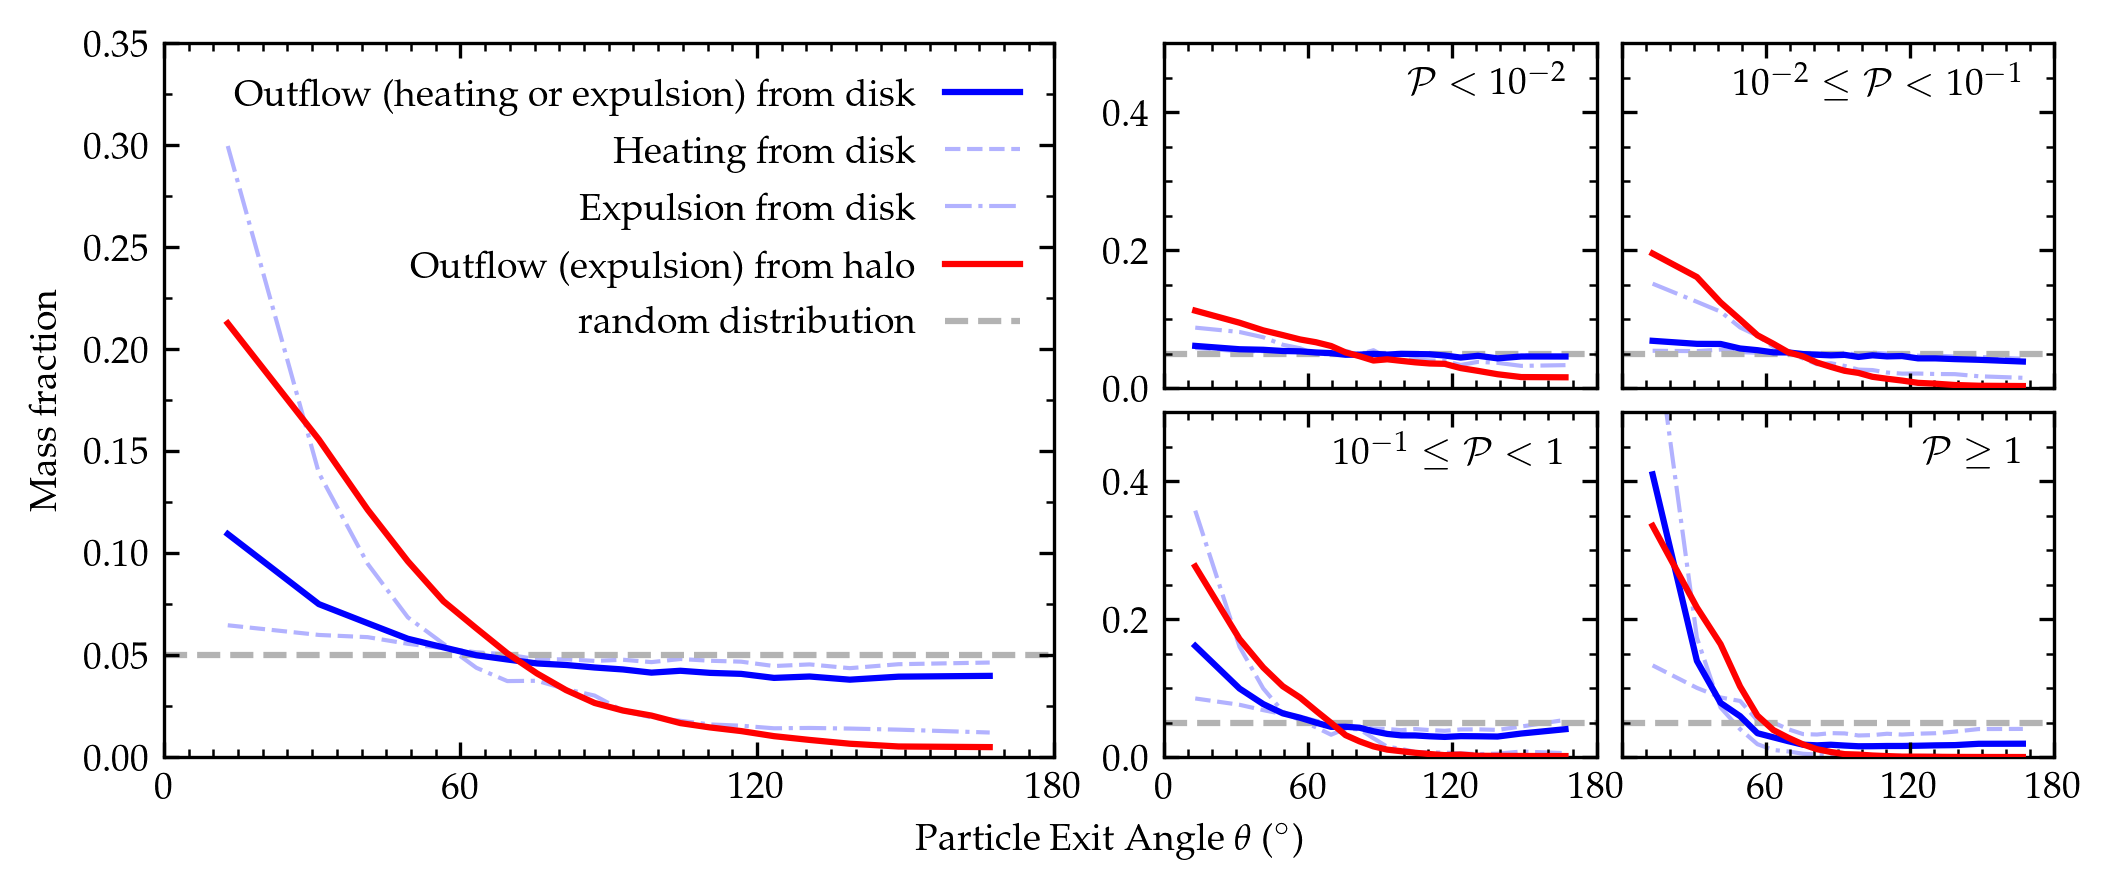

In [12]:
fig = plt.figure(dpi=300, figsize=(7,2.8), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=5, width_ratios = [1,1,0.14,1,1], figure=fig)
gs.update(hspace=0.07, wspace=0.07, top=0.98, right=0.98, left=0.08, bottom=0.13)
ax0 = plt.subplot(gs[:,:2])
ax_buffer = plt.subplot(gs[:,2])
ax1 = plt.subplot(gs[0, 3])
ax2 = plt.subplot(gs[0, 4])
ax3 = plt.subplot(gs[1, 3])
ax4 = plt.subplot(gs[1, 4])

ax_buffer.axis('off')

N = 20

plot_panel(N, ax0, ejected_merged, expelled_merged, label=True)
# ax0.annotate(r'All satellites, all timesteps', (0.05,0.95),xycoords='axes fraction',ha='left', va='top')

cond_ej = ratio_ej < 1e-2
cond_ex = ratio_ex < 1e-2 
plot_panel(N, ax1, ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)
ax1.annotate(r'$\mathcal{P} < 10^{-2}$', (0.93,0.93),xycoords='axes fraction',ha='right', va='top')
ax1.tick_params(labelbottom=False)

cond_ej = (ratio_ej >= 1e-2) & (ratio_ej < 1e-1)
cond_ex = (ratio_ex >= 1e-2) & (ratio_ex < 1e-1)
plot_panel(N, ax2, ejected_merged[cond_ej], expelled_merged[cond_ex])
ax2.annotate(r'$10^{-2} \leq \mathcal{P} < 10^{-1}$',(0.93,0.93),xycoords='axes fraction',ha='right', va='top')
ax2.tick_params(labelleft=False, labelbottom=False)

cond_ej = (ratio_ej >= 1e-1) & (ratio_ej < 1)
cond_ex = (ratio_ex >= 1e-1) & (ratio_ex < 1)
plot_panel(N, ax3, ejected_merged[cond_ej], expelled_merged[cond_ex])
ax3.annotate(r'$10^{-1} \leq \mathcal{P} < 1$',(0.93,0.93),xycoords='axes fraction',ha='right', va='top')

cond_ej = ratio_ej >= 1
cond_ex = ratio_ex >= 1
plot_panel(N, ax4, ejected_merged[cond_ej], expelled_merged[cond_ex])
ax4.annotate(r'$\mathcal{P} \geq 1$',(0.93,0.93),xycoords='axes fraction',ha='right', va='top')
ax4.tick_params(labelleft=False)


# plot the line that represents a random distribution
percent = 1/N
ax0.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')
ax1.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax2.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax3.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax4.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg = ax0.legend(frameon=False, loc='upper right')
vp = leg._legend_box._children[-1]._children[0]
for c in vp._children:
    c._children.reverse()
vp.align="right" 


# labels and ticks and such
ax0.set_xlabel('.', color=(0, 0, 0, 0))
ax0.set_ylabel('Mass fraction')
fig.text(0.53, 0.03, r'Particle Exit Angle $\theta$ ($^\circ$)', ha='center', va='center')

for a in [ax0,ax1,ax2,ax3,ax4]:
    a.set_xlim(0,180)
    a.set_ylim(0,0.5)

    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    a.tick_params(direction='in',which='both',right=True,top=True)
    
ax4.set_xticklabels([None, None, 60, 120, 180])
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.025))
ax0.set_ylim(0, 0.35)

plt.savefig('plots/theta.pdf')
plt.show()

## Examining Outliers <a class="anchor" id="outliers"></a>

There are a few outliers in the plots of expulsion rates vs. ram pressure. Here I examine the exit angles of those outlier points to see if that reveals anything. 

In [13]:
data_all = read_all_ram_pressure()

1 Returning (ejected, cooled, expelled, accreted) for h148-13...
2 Returning (ejected, cooled, expelled, accreted) for h148-28...
3 Returning (ejected, cooled, expelled, accreted) for h148-37...
4 Returning (ejected, cooled, expelled, accreted) for h148-45...
5 Returning (ejected, cooled, expelled, accreted) for h148-68...
6 Returning (ejected, cooled, expelled, accreted) for h148-80...
7 Returning (ejected, cooled, expelled, accreted) for h148-283...
8 Returning (ejected, cooled, expelled, accreted) for h148-278...
9 Returning (ejected, cooled, expelled, accreted) for h148-329...
10 Returning (ejected, cooled, expelled, accreted) for h229-20...
11 Returning (ejected, cooled, expelled, accreted) for h229-22...
12 Returning (ejected, cooled, expelled, accreted) for h229-23...
13 Returning (ejected, cooled, expelled, accreted) for h229-27...
14 Returning (ejected, cooled, expelled, accreted) for h229-55...
15 Returning (ejected, cooled, expelled, accreted) for h242-24...
16 Returning (ej

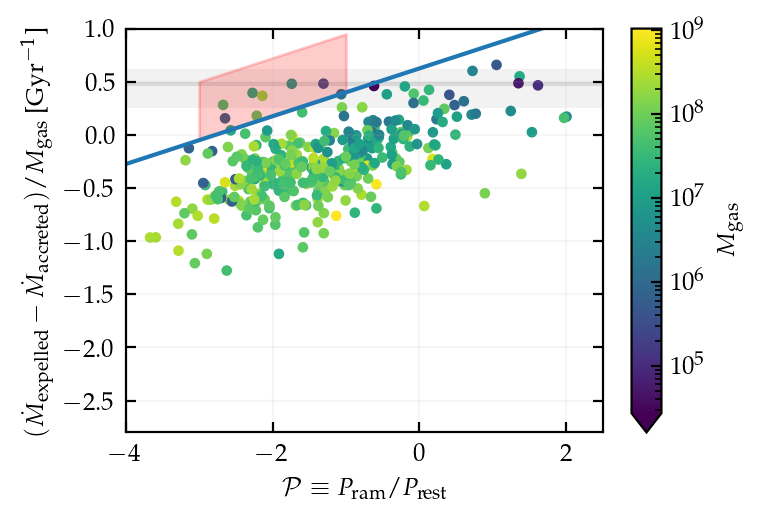

In [14]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(np.log10(data_all.ratio), np.log10(data_all.Mdot_expelled_by_Mgas), s=8, c=data_all.M_gas, norm=mpl.colors.LogNorm())
fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm expelled}-\dot{M}_{\rm accreted})/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.set_xlim(-4, 2.5)
ax.set_ylim(-2.8, 1)
ax.grid(alpha=0.1, zorder=-1000)

ax.plot([-4,3],[np.log10(3),np.log10(3)],color='0.85', zorder=-90)
ax.fill_between([-4,3],[np.log10(3-1.2),np.log10(3-1.2)],[np.log10(3+1.2),np.log10(3+1.2)], fc='0.95', zorder=-100)


ax.fill_between([-3, -1], [-0.05, 0.4], [0.5, 0.95], color='r', alpha=0.2)
p = np.polyfit([-3, -1], [-0.05, 0.4], deg=1)
ax.axline((0,p[1]), slope=p[0])
plt.show()

In [15]:
h148 = read_timesteps('h148')
h148['sim'] = 'h148'
h229 = read_timesteps('h229')
h229['sim'] = 'h229'
h242 = read_timesteps('h242')
h242['sim'] = 'h242'
h329 = read_timesteps('h329')
h329['sim'] = 'h329'
timesteps_all = pd.concat([h148,h229,h242,h329])

In [16]:
def get_halo_masses(d):
    global timesteps_all
    sim = str(d.key)[:4]
    haloid = int(str(d.key)[5:])
    t = float(d.t)
    ts = timesteps_all[(timesteps_all.z0haloid==haloid)&(timesteps_all.sim==sim)]
    ts = ts[ts.z0haloid==haloid]
    times = np.array(ts.time, dtype=float)
    M_halos = np.array(ts.mass-ts.mgas-ts.mstar, dtype=float)
    M_halo = M_halos[np.argmin(np.abs(times-t))]
    d['M_halo'] = M_halo
    d['M_halo_peak'] = np.max(M_halos)
    d['M_gas_peak'] = np.max(ts.mgas)
    return d
    
from tqdm import tqdm
tqdm.pandas()
data_all = data_all.progress_apply(get_halo_masses, axis=1)

/Users/hollis/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 512/512 [00:05<00:00, 91.03it/s] 


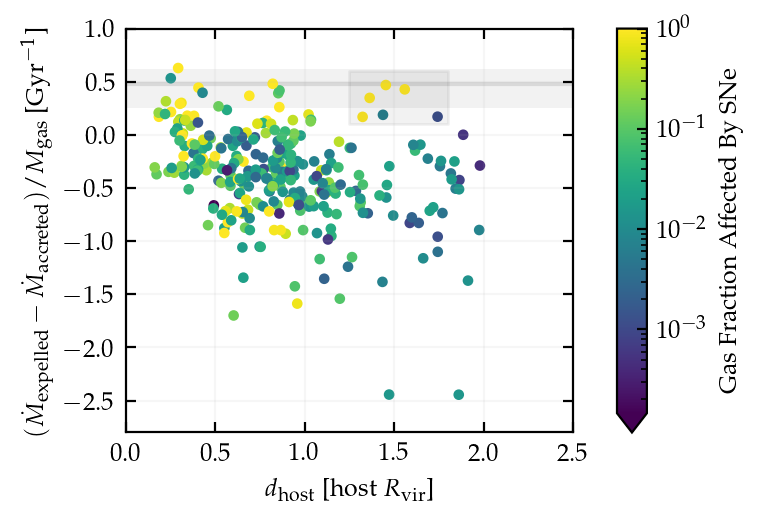

In [19]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(data_all.h1dist/data_all.hostRvir, np.log10(data_all.Mdot_expelled_by_Mgas-data_all.Mdot_accreted_by_Mgas), s=8, c=data_all.M_SNeaff/data_all.M_gas, norm=mpl.colors.LogNorm(vmax=1))
fig.colorbar(im, ax=ax, label=r'Gas Fraction Affected By SNe', extend='min')
ax.set_xlabel(r'$d_{\rm host}$ [host~$R_{\rm vir}$] ')
ax.set_ylabel(r'$(\dot{M}_{\rm expelled}-\dot{M}_{\rm accreted})/M_{\rm gas}$ [Gyr$^{-1}$]')
ax.set_xlim(0, 2.5)
ax.set_ylim(-2.8, 1)
ax.grid(alpha=0.1, zorder=-1000)

ax.plot([-4,3],[np.log10(3),np.log10(3)],color='0.85', zorder=-90)
ax.fill_between([-4,3],[np.log10(3-1.2),np.log10(3-1.2)],[np.log10(3+1.2),np.log10(3+1.2)], fc='0.95', zorder=-100)

ax.fill_between([1.25, 1.8], [0.1, 0.1], [0.6, 0.6], color='k', alpha=0.05)
plt.show()

This plot shows us that 4 of the 6 glaring outliers have fractions affected by SNe that are very high, suggesting that SNe feedback is aiding ram pressure in these cases. 